Movie Studio Analysis

Overview

Business Problem

Your company now sees all the big companies creating original video content and they want to get in on the fun. They have decided to create a new movie studio, but they don’t know anything about creating movies. You are charged with exploring what types of films are currently doing the best at the box office. You must then translate those findings into actionable insights that the head of your company's new movie studio can use to help decide what type of films to create.

In the last 10 years, which genre was the most profitable at the box office. profits between genres. 

Most popular english movies filtered by user rating???
filters - year, english, gross profit, user rating, best director
3 recommendations?
comedy vs drama


** to make 2x to 3x more profit 
set budget = movies under between 5-80 million, medium budget movies
genre of movies - filter

Data Understanding

In [1]:
import pandas as pd
import numpy as np 
from scipy import stats
import seaborn as sns
import statsmodels.api as sm

import sqlite3
import zipfile 

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read in movie budgets dataset
movie_budgets = pd.read_csv('data/tn.movie_budgets.csv.gz')
movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [3]:
# Connect and Read in SQL tables
conn = sqlite3.connect('im.db.zip')
zip_file_path = 'data/im.db.zip'

with zipfile.ZipFile('data/im.db.zip', 'r') as zip_ref:
    zip_ref.extractall('unzippedData')

database_path = 'unzippedData/im.db'
conn = sqlite3.connect(database_path)

In [5]:
schema_df = pd.read_sql("""

SELECT name
FROM sqlite_master
WHERE type= "table";

""", conn)

schema_df

,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


In [6]:
# reading the movie_basics table
movie_basics = pd.read_sql(
    """
    SELECT *
    FROM movie_basics
    WHERE start_year <= 2020
    """, conn
)
movie_basics

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"
...,...,...,...,...,...,...
146013,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.0,Drama
146014,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary
146015,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,NaN,Comedy
146016,tt9916730,6 Gunn,6 Gunn,2017,116.0,None


In [7]:
movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [9]:
#create new columns release year and release month from release date
movie_budgets['release_year'] = movie_budgets['release_date'].str[-4:].astype(int)
movie_budgets['release_month'] = movie_budgets['release_date'].str.split().str[0]

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,release_month
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279",2009,Dec
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",2011,May
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350",2019,Jun
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963",2015,May
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747",2017,Dec
...,...,...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,"$7,000",$0,$0,2018,Dec
5778,79,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495",1999,Apr
5779,80,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338",2005,Jul
5780,81,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0,2015,Sep


In [10]:
#Sanity Check
movie_budgets

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,release_month
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279",2009,Dec
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",2011,May
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350",2019,Jun
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963",2015,May
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747",2017,Dec
...,...,...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,"$7,000",$0,$0,2018,Dec
5778,79,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495",1999,Apr
5779,80,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338",2005,Jul
5780,81,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0,2015,Sep


In [11]:
#filter for release year equal and above 2000
movie_budgets_filtered = movie_budgets[movie_budgets['release_year'] >= 2000]
movie_budgets_filtered 

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,release_month
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279",2009,Dec
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",2011,May
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350",2019,Jun
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963",2015,May
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747",2017,Dec
...,...,...,...,...,...,...,...,...
5776,77,"Dec 31, 2004",The Mongol King,"$7,000",$900,$900,2004,Dec
5777,78,"Dec 31, 2018",Red 11,"$7,000",$0,$0,2018,Dec
5779,80,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338",2005,Jul
5780,81,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0,2015,Sep


In [12]:
# Remove the dollar sign and commas, then convert the values to integers for production_budget
movie_budgets_filtered['production_budget'] = movie_budgets_filtered['production_budget'].astype(str)
movie_budgets_filtered['production_budget'] = movie_budgets_filtered['production_budget'].str.replace('$', '').str.replace(',', '').astype(int)
movie_budgets_filtered['worldwide_gross'] = movie_budgets_filtered['worldwide_gross'].astype(str)
movie_budgets_filtered['worldwide_gross'] = movie_budgets_filtered['worldwide_gross'].str.replace('$', '').str.replace(',', '').astype(int)
movie_budgets_filtered['domestic_gross'] = movie_budgets_filtered['domestic_gross'].astype(str)
movie_budgets_filtered['domestic_gross'] = movie_budgets_filtered['domestic_gross'].str.replace('$', '').str.replace(',', '').astype(int)

movie_budgets_filtered


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,release_month
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2009,Dec
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,2011,May
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,2019,Jun
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,2015,May
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,2017,Dec
...,...,...,...,...,...,...,...,...
5776,77,"Dec 31, 2004",The Mongol King,7000,900,900,2004,Dec
5777,78,"Dec 31, 2018",Red 11,7000,0,0,2018,Dec
5779,80,"Jul 13, 2005",Return to the Land of Wonders,5000,1338,1338,2005,Jul
5780,81,"Sep 29, 2015",A Plague So Pleasant,1400,0,0,2015,Sep


In [13]:
#Sanity Check
movie_budgets_filtered

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,release_month
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2009,Dec
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,2011,May
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,2019,Jun
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,2015,May
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,2017,Dec
...,...,...,...,...,...,...,...,...
5776,77,"Dec 31, 2004",The Mongol King,7000,900,900,2004,Dec
5777,78,"Dec 31, 2018",Red 11,7000,0,0,2018,Dec
5779,80,"Jul 13, 2005",Return to the Land of Wonders,5000,1338,1338,2005,Jul
5780,81,"Sep 29, 2015",A Plague So Pleasant,1400,0,0,2015,Sep


In [44]:
#create net profit column
movie_budgets_filtered['net_profit'] = movie_budgets_filtered['worldwide_gross'] - movie_budgets_filtered['production_budget']
movie_budgets_filtered

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,release_month,ROI,roi,net_profit
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2009,Dec,653.257713,553.0,2351345279
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,2011,May,254.667286,155.0,635063875
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,2019,Jun,42.789243,-57.0,-200237650
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,2015,May,424.384139,324.0,1072413963
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,2017,Dec,415.369636,315.0,999721747
...,...,...,...,...,...,...,...,...,...,...,...
5776,77,"Dec 31, 2004",The Mongol King,7000,900,900,2004,Dec,12.857143,-87.0,-6100
5777,78,"Dec 31, 2018",Red 11,7000,0,0,2018,Dec,0.000000,-100.0,-7000
5779,80,"Jul 13, 2005",Return to the Land of Wonders,5000,1338,1338,2005,Jul,26.760000,-73.0,-3662
5780,81,"Sep 29, 2015",A Plague So Pleasant,1400,0,0,2015,Sep,0.000000,-100.0,-1400


In [40]:
#ORIGINAL ROI column - DO NOT RUN THIS CODE
#may not use anymore
movie_budgets_filtered['ROI'] = round(movie_budgets_filtered['worldwide_gross'] / movie_budgets_filtered['production_budget']) * 100
movie_budgets_filtered

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,release_month,ROI,roi
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2009,Dec,653.257713,553.26
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,2011,May,254.667286,154.67
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,2019,Jun,42.789243,-57.21
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,2015,May,424.384139,324.38
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,2017,Dec,415.369636,315.37
...,...,...,...,...,...,...,...,...,...,...
5776,77,"Dec 31, 2004",The Mongol King,7000,900,900,2004,Dec,12.857143,-87.14
5777,78,"Dec 31, 2018",Red 11,7000,0,0,2018,Dec,0.000000,-100.00
5779,80,"Jul 13, 2005",Return to the Land of Wonders,5000,1338,1338,2005,Jul,26.760000,-73.24
5780,81,"Sep 29, 2015",A Plague So Pleasant,1400,0,0,2015,Sep,0.000000,-100.00


In [45]:
#new ROI column with production budget subtracted
movie_budgets_filtered['roi'] = round((movie_budgets_filtered['net_profit'] / movie_budgets_filtered['production_budget']) * 100, 2)
movie_budgets_filtered

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,release_month,ROI,roi,net_profit
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2009,Dec,653.257713,553.26,2351345279
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,2011,May,254.667286,154.67,635063875
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,2019,Jun,42.789243,-57.21,-200237650
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,2015,May,424.384139,324.38,1072413963
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,2017,Dec,415.369636,315.37,999721747
...,...,...,...,...,...,...,...,...,...,...,...
5776,77,"Dec 31, 2004",The Mongol King,7000,900,900,2004,Dec,12.857143,-87.14,-6100
5777,78,"Dec 31, 2018",Red 11,7000,0,0,2018,Dec,0.000000,-100.00,-7000
5779,80,"Jul 13, 2005",Return to the Land of Wonders,5000,1338,1338,2005,Jul,26.760000,-73.24,-3662
5780,81,"Sep 29, 2015",A Plague So Pleasant,1400,0,0,2015,Sep,0.000000,-100.00,-1400


In [53]:
movie_budgets_filtered['roi'].describe()

count     4387.000000
mean       236.031814
std       1263.118508
min       -100.000000
25%        -59.755000
50%         54.470000
75%        240.275000
max      43051.790000
Name: roi, dtype: float64

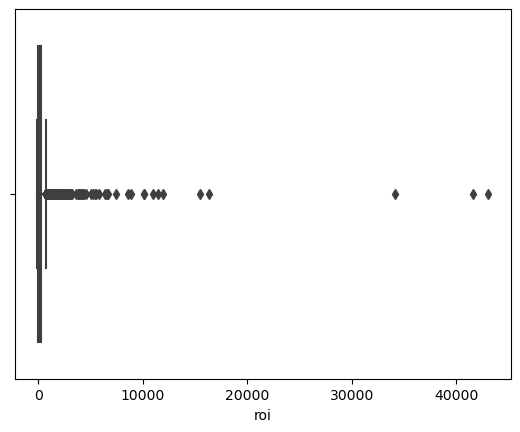

In [54]:
#using box plot to see any outliers
sns.boxplot(x=movie_budgets_filtered['roi'])
plt.show()

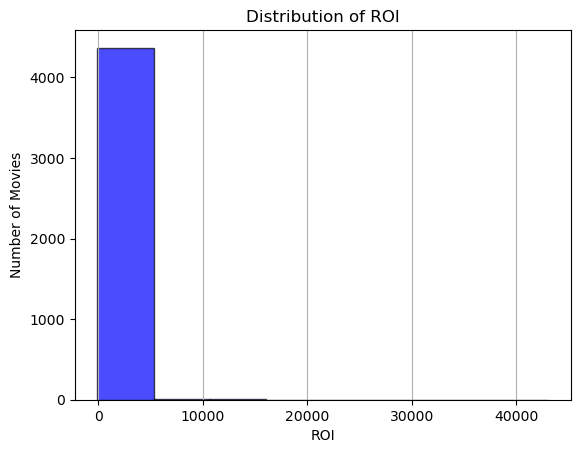

In [63]:
#histogram to compare with boxplot - not a good plot
movie_budgets_filtered['roi'].hist(bins=8, edgecolor='black', color='blue', alpha=0.7)
plt.title('Distribution of ROI')
plt.xlabel('ROI')
plt.ylabel('Number of Movies')
plt.grid(axis='y')


plt.show()

In [64]:
#new filtering ROI above 200.0
roi_test = movie_budgets_filtered[movie_budgets_filtered["roi"] >= 200.0]
roi_test

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,release_month,ROI,roi,net_profit
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2009,Dec,653.257713,553.26,2351345279
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,2015,May,424.384139,324.38,1072413963
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,2017,Dec,415.369636,315.37,999721747
5,6,"Dec 18, 2015",Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220,2015,Dec,671.016739,571.02,1747311220
6,7,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,2018,Apr,682.711400,582.71,1748134200
...,...,...,...,...,...,...,...,...,...,...,...
5766,67,"Apr 28, 2006",Clean,10000,138711,138711,2006,Apr,1387.110000,1287.11,128711
5767,68,"Jul 6, 2001",Cure,10000,94596,94596,2001,Jul,945.960000,845.96,84596
5774,75,"Oct 8, 2004",Primer,7000,424760,841926,2004,Oct,12027.514286,11927.51,834926
5775,76,"May 26, 2006",Cavite,7000,70071,71644,2006,May,1023.485714,923.49,64644


In [70]:
#filtering roi above 200.0
movie_budgets_filtered = movie_budgets_filtered[movie_budgets_filtered["roi"] >= 200.0]
movie_budgets_filtered

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,release_month,ROI,roi,net_profit
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2009,Dec,653.257713,553.26,2351345279
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,2015,May,424.384139,324.38,1072413963
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,2017,Dec,415.369636,315.37,999721747
5,6,"Dec 18, 2015",Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220,2015,Dec,671.016739,571.02,1747311220
6,7,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,2018,Apr,682.711400,582.71,1748134200
...,...,...,...,...,...,...,...,...,...,...,...
5766,67,"Apr 28, 2006",Clean,10000,138711,138711,2006,Apr,1387.110000,1287.11,128711
5767,68,"Jul 6, 2001",Cure,10000,94596,94596,2001,Jul,945.960000,845.96,84596
5774,75,"Oct 8, 2004",Primer,7000,424760,841926,2004,Oct,12027.514286,11927.51,834926
5775,76,"May 26, 2006",Cavite,7000,70071,71644,2006,May,1023.485714,923.49,64644


In [72]:
# Filter rows where the production_budget is less than or equal to 80 million
budgets = movie_budgets_filtered[movie_budgets_filtered['production_budget'] <= 80000000]
budgets

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,release_month,ROI,roi,net_profit
537,38,"Mar 23, 2012",The Hunger Games,80000000,408010692,677923379,2012,Mar,847.404224,747.40,597923379
538,39,"May 26, 2011",The Hangover Part II,80000000,254464305,586464305,2011,May,733.080381,633.08,506464305
540,41,"Feb 10, 2017",The Lego Batman Movie,80000000,175750384,310660018,2017,Feb,388.325022,288.33,230660018
541,42,"Sep 25, 2015",Hotel Transylvania 2,80000000,169700110,469500298,2015,Sep,586.875373,486.88,389500298
544,45,"May 19, 2006",Over the Hedge,80000000,155019340,343397247,2006,May,429.246559,329.25,263397247
...,...,...,...,...,...,...,...,...,...,...,...
5766,67,"Apr 28, 2006",Clean,10000,138711,138711,2006,Apr,1387.110000,1287.11,128711
5767,68,"Jul 6, 2001",Cure,10000,94596,94596,2001,Jul,945.960000,845.96,84596
5774,75,"Oct 8, 2004",Primer,7000,424760,841926,2004,Oct,12027.514286,11927.51,834926
5775,76,"May 26, 2006",Cavite,7000,70071,71644,2006,May,1023.485714,923.49,64644


In [73]:
#sanity check
budgets.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1058 entries, 537 to 5781
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 1058 non-null   int64  
 1   release_date       1058 non-null   object 
 2   movie              1058 non-null   object 
 3   production_budget  1058 non-null   int64  
 4   domestic_gross     1058 non-null   int64  
 5   worldwide_gross    1058 non-null   int64  
 6   release_year       1058 non-null   int64  
 7   release_month      1058 non-null   object 
 8   ROI                1058 non-null   float64
 9   roi                1058 non-null   float64
 10  net_profit         1058 non-null   int64  
dtypes: float64(2), int64(6), object(3)
memory usage: 99.2+ KB


In [74]:
# create new df to match goknur's df, right join on primary_title
merged_df_copy = pd.merge(budgets, movie_basics, left_on='movie', right_on='primary_title', how='inner')
merged_df_copy

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,release_month,ROI,roi,net_profit,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,38,"Mar 23, 2012",The Hunger Games,80000000,408010692,677923379,2012,Mar,847.404224,747.40,597923379,tt1392170,The Hunger Games,The Hunger Games,2012,142.0,"Action,Adventure,Sci-Fi"
1,39,"May 26, 2011",The Hangover Part II,80000000,254464305,586464305,2011,May,733.080381,633.08,506464305,tt1411697,The Hangover Part II,The Hangover Part II,2011,102.0,"Comedy,Mystery"
2,41,"Feb 10, 2017",The Lego Batman Movie,80000000,175750384,310660018,2017,Feb,388.325022,288.33,230660018,tt4116284,The Lego Batman Movie,The Lego Batman Movie,2017,104.0,"Action,Animation,Comedy"
3,42,"Sep 25, 2015",Hotel Transylvania 2,80000000,169700110,469500298,2015,Sep,586.875373,486.88,389500298,tt2510894,Hotel Transylvania 2,Hotel Transylvania 2,2015,89.0,"Animation,Comedy,Family"
4,48,"Jul 12, 2013",Grown Ups 2,80000000,133668525,247023808,2013,Jul,308.779760,208.78,167023808,tt2191701,Grown Ups 2,Grown Ups 2,2013,101.0,Comedy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
769,49,"Sep 1, 2015",Exeter,25000,0,489792,2015,Sep,1959.168000,1859.17,464792,tt2782686,Exeter,Exeter,2014,NaN,Horror
770,49,"Sep 1, 2015",Exeter,25000,0,489792,2015,Sep,1959.168000,1859.17,464792,tt4931374,Exeter,Exeter,2015,92.0,None
771,67,"Apr 28, 2006",Clean,10000,138711,138711,2006,Apr,1387.110000,1287.11,128711,tt6619196,Clean,Clean,2017,70.0,"Comedy,Drama,Horror"
772,68,"Jul 6, 2001",Cure,10000,94596,94596,2001,Jul,945.960000,845.96,84596,tt1872026,Cure,Cure,2011,93.0,Drama


In [75]:
#drop duplicates from new df
merge_copy = merged_df_copy.drop_duplicates(subset=['movie'])
merge_copy

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,release_month,ROI,roi,net_profit,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,38,"Mar 23, 2012",The Hunger Games,80000000,408010692,677923379,2012,Mar,847.404224,747.40,597923379,tt1392170,The Hunger Games,The Hunger Games,2012,142.0,"Action,Adventure,Sci-Fi"
1,39,"May 26, 2011",The Hangover Part II,80000000,254464305,586464305,2011,May,733.080381,633.08,506464305,tt1411697,The Hangover Part II,The Hangover Part II,2011,102.0,"Comedy,Mystery"
2,41,"Feb 10, 2017",The Lego Batman Movie,80000000,175750384,310660018,2017,Feb,388.325022,288.33,230660018,tt4116284,The Lego Batman Movie,The Lego Batman Movie,2017,104.0,"Action,Animation,Comedy"
3,42,"Sep 25, 2015",Hotel Transylvania 2,80000000,169700110,469500298,2015,Sep,586.875373,486.88,389500298,tt2510894,Hotel Transylvania 2,Hotel Transylvania 2,2015,89.0,"Animation,Comedy,Family"
4,48,"Jul 12, 2013",Grown Ups 2,80000000,133668525,247023808,2013,Jul,308.779760,208.78,167023808,tt2191701,Grown Ups 2,Grown Ups 2,2013,101.0,Comedy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
766,38,"Mar 18, 2016",Krisha,30000,144822,144822,2016,Mar,482.740000,382.74,114822,tt4266638,Krisha,Krisha,2015,83.0,Drama
767,48,"Jan 14, 2000",The Terrorist,25000,195043,195043,2000,Jan,780.172000,680.17,170043,tt9248762,The Terrorist,The Terrorist,2018,NaN,Thriller
768,49,"Sep 1, 2015",Exeter,25000,0,489792,2015,Sep,1959.168000,1859.17,464792,tt1945044,Exeter,Exeter,2015,91.0,"Horror,Mystery,Thriller"
771,67,"Apr 28, 2006",Clean,10000,138711,138711,2006,Apr,1387.110000,1287.11,128711,tt6619196,Clean,Clean,2017,70.0,"Comedy,Drama,Horror"


In [76]:
#Rename the dataframe to appropriate name and save cleaned dataset as CSV
movie_df = merge_copy
movie_df.to_csv('data/movie.df.csv', index=False)

In [77]:
#sanity check
movie_df

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,release_month,ROI,roi,net_profit,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,38,"Mar 23, 2012",The Hunger Games,80000000,408010692,677923379,2012,Mar,847.404224,747.40,597923379,tt1392170,The Hunger Games,The Hunger Games,2012,142.0,"Action,Adventure,Sci-Fi"
1,39,"May 26, 2011",The Hangover Part II,80000000,254464305,586464305,2011,May,733.080381,633.08,506464305,tt1411697,The Hangover Part II,The Hangover Part II,2011,102.0,"Comedy,Mystery"
2,41,"Feb 10, 2017",The Lego Batman Movie,80000000,175750384,310660018,2017,Feb,388.325022,288.33,230660018,tt4116284,The Lego Batman Movie,The Lego Batman Movie,2017,104.0,"Action,Animation,Comedy"
3,42,"Sep 25, 2015",Hotel Transylvania 2,80000000,169700110,469500298,2015,Sep,586.875373,486.88,389500298,tt2510894,Hotel Transylvania 2,Hotel Transylvania 2,2015,89.0,"Animation,Comedy,Family"
4,48,"Jul 12, 2013",Grown Ups 2,80000000,133668525,247023808,2013,Jul,308.779760,208.78,167023808,tt2191701,Grown Ups 2,Grown Ups 2,2013,101.0,Comedy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
766,38,"Mar 18, 2016",Krisha,30000,144822,144822,2016,Mar,482.740000,382.74,114822,tt4266638,Krisha,Krisha,2015,83.0,Drama
767,48,"Jan 14, 2000",The Terrorist,25000,195043,195043,2000,Jan,780.172000,680.17,170043,tt9248762,The Terrorist,The Terrorist,2018,NaN,Thriller
768,49,"Sep 1, 2015",Exeter,25000,0,489792,2015,Sep,1959.168000,1859.17,464792,tt1945044,Exeter,Exeter,2015,91.0,"Horror,Mystery,Thriller"
771,67,"Apr 28, 2006",Clean,10000,138711,138711,2006,Apr,1387.110000,1287.11,128711,tt6619196,Clean,Clean,2017,70.0,"Comedy,Drama,Horror"


In [78]:
#dropping unnecessary columns
movie_df.drop(columns = ["id", "start_year", "original_title", "runtime_minutes"], inplace = True)

In [79]:
#sanity check
movie_df

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,release_month,ROI,roi,net_profit,movie_id,primary_title,genres
0,"Mar 23, 2012",The Hunger Games,80000000,408010692,677923379,2012,Mar,847.404224,747.40,597923379,tt1392170,The Hunger Games,"Action,Adventure,Sci-Fi"
1,"May 26, 2011",The Hangover Part II,80000000,254464305,586464305,2011,May,733.080381,633.08,506464305,tt1411697,The Hangover Part II,"Comedy,Mystery"
2,"Feb 10, 2017",The Lego Batman Movie,80000000,175750384,310660018,2017,Feb,388.325022,288.33,230660018,tt4116284,The Lego Batman Movie,"Action,Animation,Comedy"
3,"Sep 25, 2015",Hotel Transylvania 2,80000000,169700110,469500298,2015,Sep,586.875373,486.88,389500298,tt2510894,Hotel Transylvania 2,"Animation,Comedy,Family"
4,"Jul 12, 2013",Grown Ups 2,80000000,133668525,247023808,2013,Jul,308.779760,208.78,167023808,tt2191701,Grown Ups 2,Comedy
...,...,...,...,...,...,...,...,...,...,...,...,...,...
766,"Mar 18, 2016",Krisha,30000,144822,144822,2016,Mar,482.740000,382.74,114822,tt4266638,Krisha,Drama
767,"Jan 14, 2000",The Terrorist,25000,195043,195043,2000,Jan,780.172000,680.17,170043,tt9248762,The Terrorist,Thriller
768,"Sep 1, 2015",Exeter,25000,0,489792,2015,Sep,1959.168000,1859.17,464792,tt1945044,Exeter,"Horror,Mystery,Thriller"
771,"Apr 28, 2006",Clean,10000,138711,138711,2006,Apr,1387.110000,1287.11,128711,tt6619196,Clean,"Comedy,Drama,Horror"


In [80]:
movie_df["genres"].value_counts()

genres
Drama                         36
Horror,Mystery,Thriller       25
Comedy,Drama,Romance          24
Comedy,Drama                  21
Documentary                   21
                              ..
Action,Adventure,Horror        1
Action,Adventure,Biography     1
Crime,Drama,Family             1
Adventure,Family,Sci-Fi        1
Comedy,Drama,Horror            1
Name: count, Length: 141, dtype: int64

# Statstical Analysis 

# Graphs

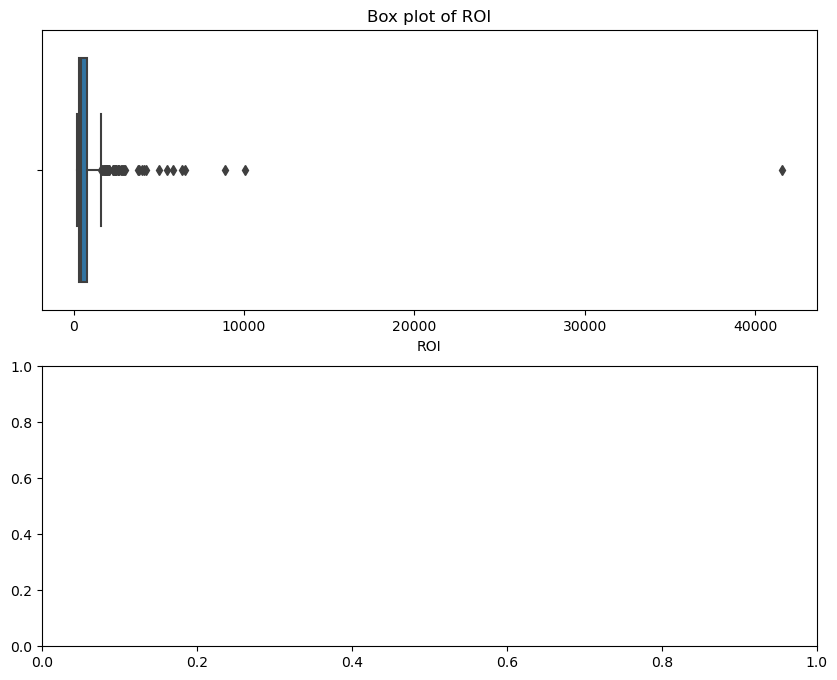

In [91]:
#box plot 
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
sns.boxplot(x=movie_df['roi'], ax=ax[0])
ax[0].set_title('Box plot of ROI')
ax[0].set_xlabel('ROI')

plt.show()

In [81]:
#calculate central tendency measures - mean, median, mode
movie_df['roi'].describe()

count      514.000000
mean       830.796965
std       2043.422344
min        200.860000
25%        288.120000
50%        445.300000
75%        808.652500
max      41556.470000
Name: roi, dtype: float64

In [92]:
#removing the outlier
max_value = movie_df['roi'].max()
movie_df = movie_df[movie_df['roi'] != max_value]

In [93]:
#sanity check for outlier
movie_df

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,release_month,ROI,roi,net_profit,movie_id,primary_title,genres
0,"Mar 23, 2012",The Hunger Games,80000000,408010692,677923379,2012,Mar,847.404224,747.40,597923379,tt1392170,The Hunger Games,"Action,Adventure,Sci-Fi"
1,"May 26, 2011",The Hangover Part II,80000000,254464305,586464305,2011,May,733.080381,633.08,506464305,tt1411697,The Hangover Part II,"Comedy,Mystery"
2,"Feb 10, 2017",The Lego Batman Movie,80000000,175750384,310660018,2017,Feb,388.325022,288.33,230660018,tt4116284,The Lego Batman Movie,"Action,Animation,Comedy"
3,"Sep 25, 2015",Hotel Transylvania 2,80000000,169700110,469500298,2015,Sep,586.875373,486.88,389500298,tt2510894,Hotel Transylvania 2,"Animation,Comedy,Family"
4,"Jul 12, 2013",Grown Ups 2,80000000,133668525,247023808,2013,Jul,308.779760,208.78,167023808,tt2191701,Grown Ups 2,Comedy
...,...,...,...,...,...,...,...,...,...,...,...,...,...
766,"Mar 18, 2016",Krisha,30000,144822,144822,2016,Mar,482.740000,382.74,114822,tt4266638,Krisha,Drama
767,"Jan 14, 2000",The Terrorist,25000,195043,195043,2000,Jan,780.172000,680.17,170043,tt9248762,The Terrorist,Thriller
768,"Sep 1, 2015",Exeter,25000,0,489792,2015,Sep,1959.168000,1859.17,464792,tt1945044,Exeter,"Horror,Mystery,Thriller"
771,"Apr 28, 2006",Clean,10000,138711,138711,2006,Apr,1387.110000,1287.11,128711,tt6619196,Clean,"Comedy,Drama,Horror"


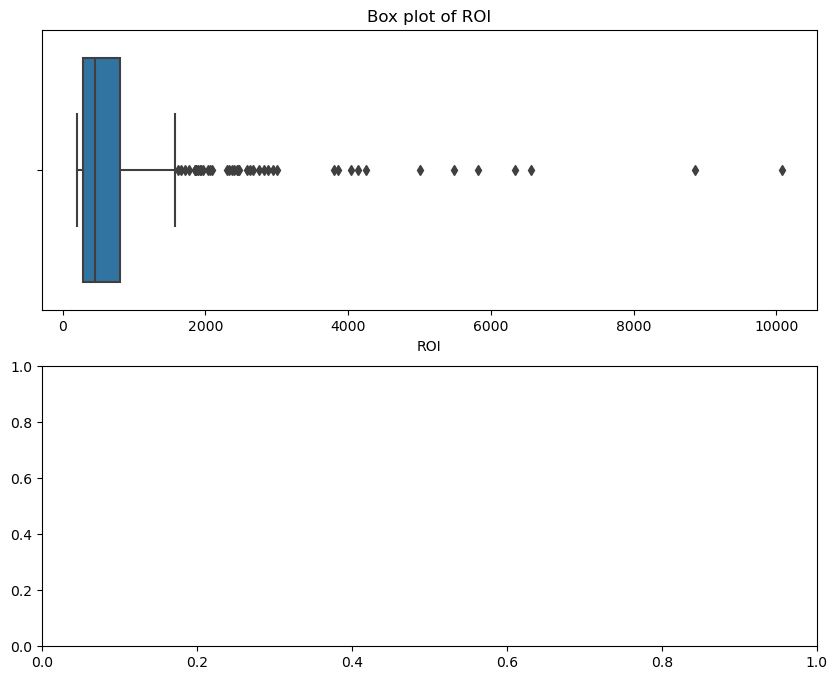

In [94]:
#box plot 
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
sns.boxplot(x=movie_df['roi'], ax=ax[0])
ax[0].set_title('Box plot of ROI')
ax[0].set_xlabel('ROI')

plt.show()

In [104]:
#Correlation Coefficient to see relation between production_budget and ROI

corr_coeff = np.corrcoef(movie_df['production_budget'], movie_df['net_profit'])[0, 1]
print(f"Pearson's correlation coefficient: {corr_coeff:.2f}")

Pearson's correlation coefficient: 0.67


A value closer to 1 implies a strong positive correlation.
A value closer to -1 implies a strong negative correlation.
A value closer to 0 implies little to no correlation.

In [ ]:
#Hypothesis Test between production_budget and ROI
HA: There is a significant difference to budget and ROI 
H0: There is no difference to budget and ROI


In [96]:
hypothesis_mean = 0

# Select the column containing the 'roi' values and compute the sample mean
sample_data = movie_df['roi']
sample_mean = sample_data.mean()

# Perform a one-sample t-test
t_statistic, p_value = stats.ttest_1samp(sample_data, hypothesis_mean)

# Output the results
print(f"Sample Mean: {sample_mean}")
print(f"T-Statistic: {t_statistic}")
print(f"P-Value: {p_value}")

# Check for significance
alpha = 0.05 
if p_value < alpha:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null hypothesis")


Sample Mean: 751.4096881091618
T-Statistic: 17.572513596213923
P-Value: 1.9375440419141796e-54
Reject the null hypothesis


In [105]:
hypothesis_mean = 0

# Select the column containing the netprofit values and compute the sample mean
sample_data = movie_df['net_profit']
sample_mean = sample_data.mean()

# Perform a one-sample t-test
t_statistic, p_value = stats.ttest_1samp(sample_data, hypothesis_mean)

# Output the results
print(f"Sample Mean: {sample_mean}")
print(f"T-Statistic: {t_statistic}")
print(f"P-Value: {p_value}")

# Check for significance
alpha = 0.05 
if p_value < alpha:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null hypothesis")

Sample Mean: 113519763.81871346
T-Statistic: 19.047082111966354
P-Value: 1.5226398203288797e-61
Reject the null hypothesis


In [98]:
# Simple Linear Regression
X = movie_df['production_budget']
y = movie_df['roi']
X = sm.add_constant(X)  # Adds a constant term to the predictor
model = sm.OLS(y, X)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    roi   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     36.60
Date:                Thu, 26 Oct 2023   Prob (F-statistic):           2.81e-09
Time:                        20:39:31   Log-Likelihood:                -4236.9
No. Observations:                 513   AIC:                             8478.
Df Residuals:                     511   BIC:                             8486.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              1019.7470     60.638     16.817      0.000     900.617    1138.877
production_budget -1.225e-05   2.02e-06     -6.050      0.000   -1.62e-05   -8.27e-06
==============================================================================
Omnibus:                      542.407   Durbin-Watson:                   1.258
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            25475.176
Skew:                           4.846   Prob(JB):                         0.00
Kurtosis:                      36.134   Cond. No.                     4.39e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.39e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [106]:
# Simple Linear Regression budget vs net_profit
X = movie_df['production_budget']
y = movie_df['net_profit']
X = sm.add_constant(X)
model = sm.OLS(y, X)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             net_profit   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.447
Method:                 Least Squares   F-statistic:                     414.4
Date:                Thu, 26 Oct 2023   Prob (F-statistic):           6.70e-68
Time:                        20:46:47   Log-Likelihood:                -10179.
No. Observations:                 513   AIC:                         2.036e+04
Df Residuals:                     511   BIC:                         2.037e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              1.671e+07    6.5e+06      2.570      0.010    3.94e+06    2.95e+07
production_budget     4.4194      0.217     20.357      0.000       3.993       4.846
==============================================================================
Omnibus:                      364.120   Durbin-Watson:                   1.549
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5141.560
Skew:                           2.980   Prob(JB):                         0.00
Kurtosis:                      17.318   Cond. No.                     4.39e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.39e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [107]:
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(movie_df["production_budget"], movie_df["roi"])
print("Slope:", slope)
print("Intercept:", intercept)
print("R-value:", r_value)
print("P-value:", p_value)
print("Standard Error:", std_err)

Slope: -1.2249829407653422e-05
Intercept: 1019.7469731773951
R-value: -0.2585294559293963
P-value: 2.805335894740158e-09
Standard Error: 2.024828300196443e-06


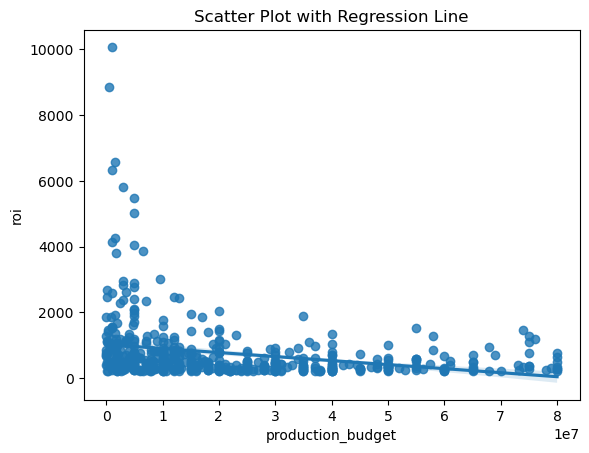

In [100]:
# Scatter plot with regression line
sns.regplot(x='production_budget', y='roi', data=movie_df)
plt.title('Scatter Plot with Regression Line')
plt.show()

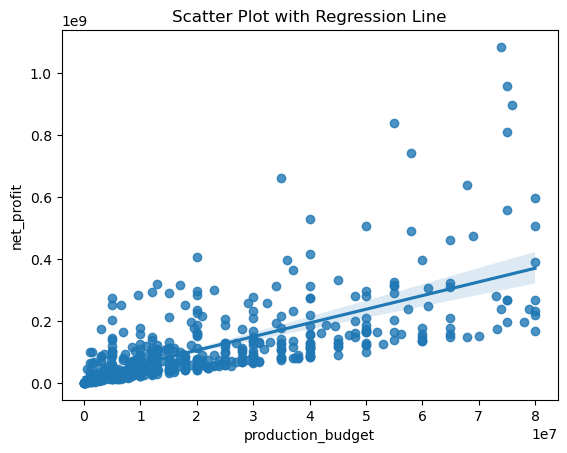

In [108]:
# Scatter plot with regression line
sns.regplot(x='production_budget', y='net_profit', data=movie_df)
plt.title('Scatter Plot with Regression Line')
plt.show()

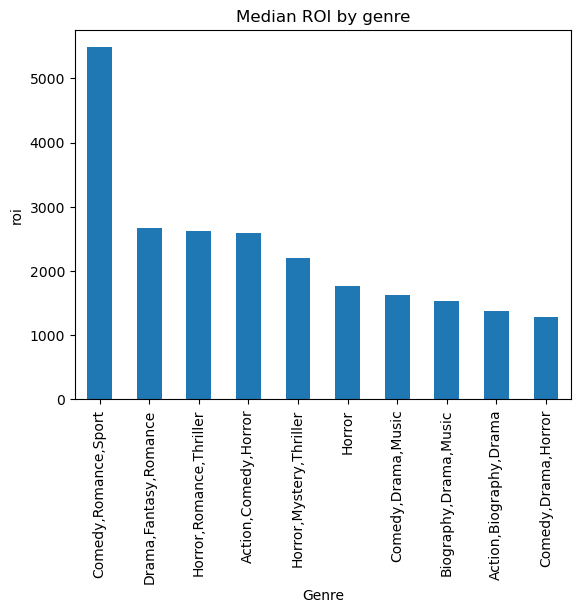

In [103]:
#Bar chart for top 10 genres
top_10_genre = movie_df.groupby("genres")["roi"].mean().sort_values(ascending = False).head(10)
top_10_genre.plot(kind = "bar")
top_genre_highest_roi = movie_df.groupby('Primary_Genre')['roi'].median().sort_values(ascending=False).head(7)
plt.bar(top_genre_highest_roi.index, top_genre_highest_roi.values)
plt.xlabel('Primary Genre')
plt.ylabel('ROI')
plt.title('Genres with Highest ROI')
plt.xticks(rotation=45)
plt.show()